Practical 2 - Analyzing a provided RNA-Seq dataset and performing differential gene expression 
analysis.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# PyDESeq2 (DESeq2 implementation in Python)
from pydeseq2.utils import load_example_data
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats   # <-- corrected import for v0.5.2

In [2]:
# ================================
# 1. Load Example Dataset
# ================================
counts_df = load_example_data()

# Transpose to samples × genes (important for PyDESeq2)
counts_df = counts_df.T  

# Build metadata: one row per sample
conditions = ['Control'] * (counts_df.shape[0] // 2) + ['Treatment'] * (counts_df.shape[0] - counts_df.shape[0] // 2)
metadata_df = pd.DataFrame({'condition': conditions}, index=counts_df.index)

# Duplicate samples to increase sample size (testing only)
counts_df = pd.concat([counts_df, counts_df], axis=0)
metadata_df = pd.concat([metadata_df, metadata_df], axis=0)

# (Optional) Rename indices to avoid duplicates
counts_df.index = [f"sample_{i}" for i in range(counts_df.shape[0])]
metadata_df.index = counts_df.index

print("Counts shape:", counts_df.shape)   # now larger
print("Metadata shape:", metadata_df.shape)

print("Counts data (first 5 rows):")
print(counts_df.head())

print("\nMetadata:")
print(metadata_df.head())

Counts shape: (20, 100)
Metadata shape: (20, 1)
Counts data (first 5 rows):
          sample1  sample2  sample3  sample4  sample5  sample6  sample7  \
sample_0       12        1        4        1        1        0        0   
sample_1       21       44        4       10       11        8       14   
sample_2        4        2       11        2        6        2       17   
sample_3      130       63      180      100      135       36      159   
sample_4       18       11       21       44       16       26       11   

          sample8  sample9  sample10  ...  sample91  sample92  sample93  \
sample_0        2        5        18  ...         0         9         5   
sample_1       19       19        11  ...        31        43        13   
sample_2       11        9         8  ...        11         4        12   
sample_3       60       66       157  ...       119        86       112   
sample_4       19        7        35  ...        50        41        21   

          sample94  sa

In [3]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df,
    design_factors="condition"  # or design="~ condition"
)
dds.deseq2()

C:\Users\ISHA\AppData\Local\Temp\ipykernel_21840\720644375.py:1: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.09 seconds.

Fitting dispersion trend curve...
C:\Users\ISHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydeseq2\dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 0 outlier genes.



In [4]:
# ================================
# 3. Differential Expression Analysis
# ================================
# Compare Treatment vs Control
stat_res = DeseqStats(dds, contrast=["condition", "Treatment", "Control"])
stat_res.summary()  # prints result summary

# Get results as a DataFrame
results_df = stat_res.results_df
print("\nDifferential Expression Results (first 10 rows):")
print(results_df.head(10))

Running Wald tests...
... done in 0.08 seconds.



Log2 fold change & Wald test p-value: condition Treatment vs Control
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
sample1    15.948319       -0.563362  0.379538 -1.484336  0.137720  0.436502
sample2    20.071993        0.854608  0.424316  2.014083  0.044001  0.205071
sample3    17.982042       -0.393887  0.446418 -0.882327  0.377600  0.740392
sample4    15.513719        0.125422  0.408826  0.306786  0.759006  0.983844
sample5    13.329567       -0.145292  0.353282 -0.411264  0.680879  0.920106
...              ...             ...       ...       ...       ...       ...
sample96   15.487539        0.281863  0.371836  0.758031  0.448433  0.764655
sample97   12.889048       -0.054065  0.345895 -0.156303  0.875794  0.997873
sample98   16.679672       -0.033073  0.423334 -0.078125  0.937729  0.997873
sample99   24.093650       -0.019237  0.395481 -0.048643  0.961204  0.997873
sample100  20.405656        0.377847  0.463416  0.815353  0.414870  0.754310

[100 r

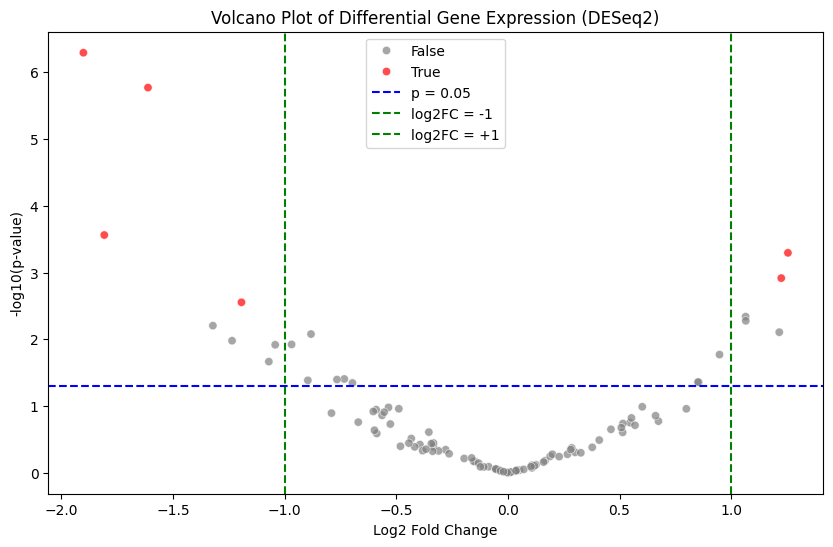

In [5]:
# ================================
# 4. Volcano Plot
# ================================
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="log2FoldChange", 
    y=-np.log10(results_df["pvalue"]),
    hue=results_df["padj"] < 0.05,
    palette={True: "red", False: "grey"},
    alpha=0.7
)

# Add cutoffs
plt.axhline(-np.log10(0.05), color="blue", linestyle="--", label="p = 0.05")
plt.axvline(-1, color="green", linestyle="--", label="log2FC = -1")
plt.axvline(1, color="green", linestyle="--", label="log2FC = +1")

plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of Differential Gene Expression (DESeq2)")
plt.legend()
plt.show()

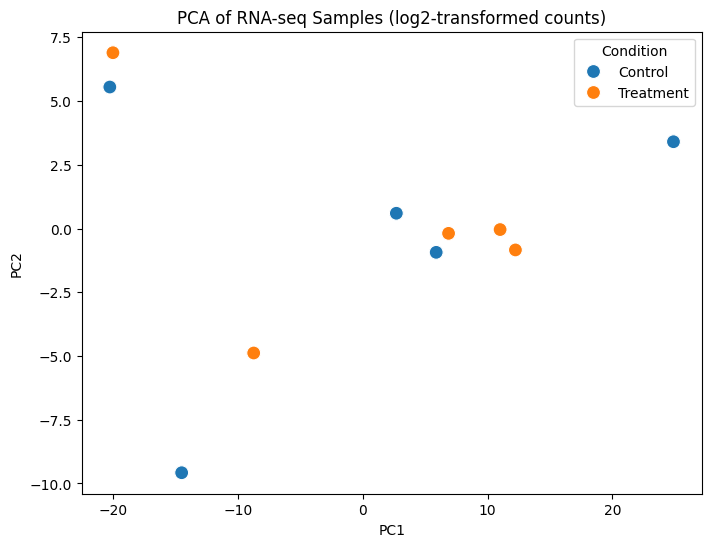

In [6]:
# ================================
# 5. PCA Plot of Samples
# ================================
# Log-transform counts (add 1 to avoid log(0))
norm_counts = np.log2(counts_df + 1)

# Run PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(norm_counts)

# Create DataFrame for plotting
pca_df = pd.DataFrame(pc, columns=["PC1", "PC2"], index=counts_df.index)
pca_df["Condition"] = metadata_df["condition"]

# Plot PCA
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Condition", s=100)
plt.title("PCA of RNA-seq Samples (log2-transformed counts)")
plt.show()